In [1]:
import numpy as np
from pendulum import PendulumNoCtrl
from matplotlib import pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [2]:
raw_data = np.loadtxt("../AEMG_new/pendulum_lqr_0.1_1step_1M.txt",delimiter=",")
print(raw_data.shape)

(1000000, 4)


In [3]:
env = PendulumNoCtrl()
bounds = env.get_transformed_state_bounds()

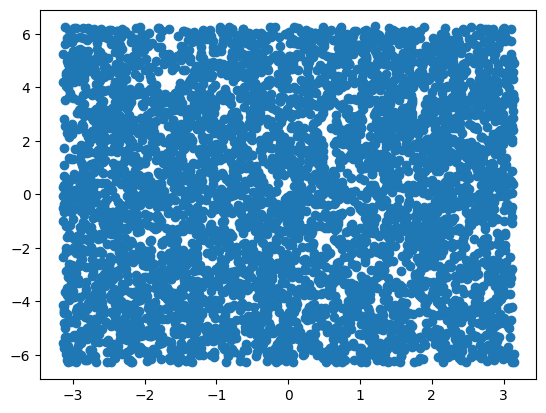

In [8]:
idxs = np.random.randint(0, 100000, 5000)
plt.scatter(raw_data[idxs, 0], raw_data[idxs, 1])
plt.savefig('scatter_raw_data.png')

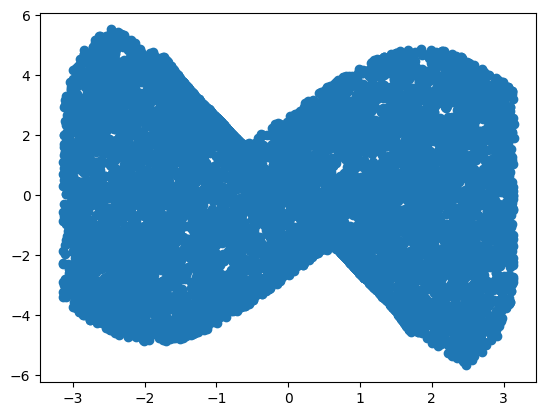

In [9]:
idxs = np.random.randint(0, 100000, 10000)
plt.scatter(raw_data[idxs, 2], raw_data[idxs, 3])
plt.savefig('scatter_raw_data.png')

In [28]:
raw_dat = np.array(raw_data)
dat = np.zeros((raw_dat.shape[0],8))
for i in tqdm(range(dat.shape[0])):
    # Transform the state
    dat[i,:4] = env.transform(raw_dat[i,:2])
    dat[i,:4] = (dat[i,:4] - bounds[:,0])/(bounds[:,1] - bounds[:,0])
    # Transform the next state
    dat[i,4:] = env.transform(raw_dat[i,2:])
    dat[i,4:] = (dat[i,4:] - bounds[:,0])/(bounds[:,1] - bounds[:,0])

 15%|██████████████▏                                                                                  | 364480/2500000 [00:04<00:25, 85251.84it/s]


KeyboardInterrupt: 

In [40]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, Xt):
        if not torch.is_tensor(Xt):
            self.Xt = torch.from_numpy(Xt).float()
            # self.Xnext = torch.from_numpy(Xnext).float()
    def __len__(self):
        return len(self.Xt)
    def __getitem__(self,i):
        return self.Xt[i]
    
dataset_size = raw_dat.shape[0]
batch_size = 1024

dat_tr = dat[:int(0.8*dataset_size),:]
dat_te = dat[int(0.8*dataset_size):,:]
raw_dat_te = raw_dat[int(0.8*dataset_size):,:]

train_dataset = CustomDataset(dat_tr[:,:4])
val_dataset = CustomDataset(dat_te[:,:4])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [47]:
class Encoder(nn.Module):
    def __init__(self,input_shape,lower_shape):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_shape, 512),
            nn.ReLU(True), 
            nn.Linear(512, 512), 
            nn.ReLU(True), 
            nn.Linear(512, lower_shape),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

class Decoder(nn.Module):
    def __init__(self,lower_shape,input_shape):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(lower_shape, 512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.ReLU(True), 
            nn.Linear(512, input_shape),
            nn.Sigmoid() 
            )
    def forward(self, x):
        x = self.decoder(x)
        return x

In [48]:
encoder = Encoder(4, 2)
decoder = Decoder(2, 4)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(set(list(encoder.parameters()) + 
list(decoder.parameters())), lr=1e-3)

In [49]:
train_losses = []
val_losses = []

latent_coeff = 0.0
epochs = 10

for epoch in tqdm(range(epochs)):
    current_train_loss = 0.0
    epoch_train_loss = 0.0
    latent_coeff = 1. # epoch/epochs

    encoder.train()
    decoder.train()
    for i, data in enumerate(train_loader, 0):
        x_t  = data

        optimizer.zero_grad()

        z_t = encoder(x_t)
        x_t_pred = decoder(z_t)
        # z_tau_pred = dynamics(z_t)
        # x_tau_pred = decoder(z_tau_pred.detach())
        # z_tau = encoder(x_tau)

        loss_ae1 = criterion(x_t_pred, x_t)
        # loss_ae2 = criterion(x_tau_pred, x_tau)
        # loss_dyn = criterion(z_tau_pred, z_tau.detach())

        
        loss = loss_ae1 # + loss_ae2 + (latent_coeff * loss_dyn)
        loss.backward()
        

        optimizer.step()


        current_train_loss += loss.item()
        epoch_train_loss += loss.item()
        # wandb.log({
        #     "train/loss_ae1": loss_ae1.detach(),
        #     "train/loss_ae2": loss_ae2.detach(),
        #     "train/loss_dyn": loss_dyn.detach(),
        #     "train/total_loss": loss.detach(),
        # })
        
        if (i+1) % 100 == 0:
            print("Loss after mini-batch ",i+1,": ", current_train_loss)
            current_train_loss = 0.0
    
    epoch_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    with torch.no_grad():
        epoch_val_loss = 0.0
        encoder.eval()
        decoder.eval()
        for i, data in enumerate(val_loader, 0):
            x_t  = data

            z_t = encoder(x_t)
            x_t_pred = decoder(z_t)
            # z_tau_pred = dynamics(z_t)
            # x_tau_pred = decoder(z_tau_pred)
            # z_tau = encoder(x_tau)

            loss_ae1 = criterion(x_t_pred, x_t)
            # loss_ae2 = criterion(x_tau_pred, x_tau)
            # loss_dyn = criterion(z_tau_pred, z_tau)

            epoch_val_loss += loss_ae1.item() # + loss_ae2.item() + (latent_coeff * loss_dyn.item())

        # wandb.log({
        #     "train/loss_ae1": loss_ae1.detach(),
        #     "train/loss_ae2": loss_ae2.detach(),
        #     "train/loss_dyn": loss_dyn.detach(),
        #     "train/total_loss": epoch_val_loss.detach(),
        # })
        
        # scheduler.step(epoch_val_loss)
        epoch_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)


    print('train loss:', epoch_train_loss, 'test loss:', epoch_val_loss)

  0%|                                                    | 0/10 [00:00<?, ?it/s]

Loss after mini-batch  100 :  0.6246937041869387
Loss after mini-batch  200 :  0.04786463177879341
Loss after mini-batch  300 :  0.04377502703573555
Loss after mini-batch  400 :  0.040709506632993
Loss after mini-batch  500 :  0.0353748929919675
Loss after mini-batch  600 :  0.030599422767409123
Loss after mini-batch  700 :  0.02304186680703424


 10%|████▍                                       | 1/10 [00:07<01:03,  7.08s/it]

train loss: 0.0011011818503418936 test loss: 0.00011757267874395902
Loss after mini-batch  100 :  0.011022488666640129
Loss after mini-batch  200 :  0.009660834741225699
Loss after mini-batch  300 :  0.007329044492507819
Loss after mini-batch  400 :  0.006588860886040493
Loss after mini-batch  500 :  0.0059251488200970925
Loss after mini-batch  600 :  0.005393977746280143
Loss after mini-batch  700 :  0.005798151119961403


 20%|████████▊                                   | 2/10 [00:16<01:08,  8.54s/it]

train loss: 6.982729472933769e-05 test loss: 4.441977994340087e-05
Loss after mini-batch  100 :  0.00696999619322014
Loss after mini-batch  200 :  0.0034689762669586344
Loss after mini-batch  300 :  0.003490172683086712
Loss after mini-batch  400 :  0.003768726662201516
Loss after mini-batch  500 :  0.0037135032453079475
Loss after mini-batch  600 :  0.00530022944076336
Loss after mini-batch  700 :  0.0030087485693002236


 30%|█████████████▏                              | 3/10 [00:26<01:02,  9.00s/it]

train loss: 4.150078066371364e-05 test loss: 2.8239067126619654e-05
Loss after mini-batch  100 :  0.002747127990005538
Loss after mini-batch  200 :  0.0038126962826936506
Loss after mini-batch  300 :  0.002561210580097395
Loss after mini-batch  400 :  0.002983386169944424
Loss after mini-batch  500 :  0.002868271747502149
Loss after mini-batch  600 :  0.003023257327186002
Loss after mini-batch  700 :  0.003065555241846596


 40%|█████████████████▌                          | 4/10 [00:35<00:55,  9.21s/it]

train loss: 2.9596744351532406e-05 test loss: 3.240225215468316e-05
Loss after mini-batch  100 :  0.002619131576466316
Loss after mini-batch  200 :  0.003300705079709587
Loss after mini-batch  300 :  0.002553806761170563
Loss after mini-batch  400 :  0.0021093520313115732
Loss after mini-batch  500 :  0.0027089156610600185
Loss after mini-batch  600 :  0.0022255728817981435
Loss after mini-batch  700 :  0.0020796260982933745


 50%|██████████████████████                      | 5/10 [00:45<00:46,  9.34s/it]

train loss: 2.5733547606374077e-05 test loss: 2.1215103743088548e-05
Loss after mini-batch  100 :  0.0024202267468353966
Loss after mini-batch  200 :  0.001945294600318448
Loss after mini-batch  300 :  0.0023323332188738277
Loss after mini-batch  400 :  0.0025057189386643586
Loss after mini-batch  500 :  0.0019080594611295965
Loss after mini-batch  600 :  0.0015857547514315229
Loss after mini-batch  700 :  0.0025814745222305646


 60%|██████████████████████████▍                 | 6/10 [00:54<00:37,  9.28s/it]

train loss: 2.1438694794594488e-05 test loss: 2.1270444184832444e-05
Loss after mini-batch  100 :  0.0017934076422534417
Loss after mini-batch  200 :  0.0019453041431916063
Loss after mini-batch  300 :  0.0018670871759240981
Loss after mini-batch  400 :  0.0017531497855998168
Loss after mini-batch  500 :  0.0018407197221677052
Loss after mini-batch  600 :  0.002082046881696442
Loss after mini-batch  700 :  0.0025228876938854228


 70%|██████████████████████████████▊             | 7/10 [01:03<00:27,  9.25s/it]

train loss: 1.9207561091669916e-05 test loss: 1.5694332599808578e-05
Loss after mini-batch  100 :  0.0017187195990118198
Loss after mini-batch  200 :  0.0017770048225429491
Loss after mini-batch  300 :  0.001498518057360343
Loss after mini-batch  400 :  0.0017772118844732177
Loss after mini-batch  500 :  0.0022680752890664735
Loss after mini-batch  600 :  0.0015996986089703569
Loss after mini-batch  700 :  0.001468200369799888


 80%|███████████████████████████████████▏        | 8/10 [01:12<00:18,  9.22s/it]

train loss: 1.6968326025146053e-05 test loss: 2.0417428830263147e-05
Loss after mini-batch  100 :  0.0016234037052527128
Loss after mini-batch  200 :  0.0014990588888394996
Loss after mini-batch  300 :  0.0015320596326091618
Loss after mini-batch  400 :  0.0014742681473762786
Loss after mini-batch  500 :  0.0016252317154794582
Loss after mini-batch  600 :  0.0012335471612914262
Loss after mini-batch  700 :  0.0018158795915041992


 90%|███████████████████████████████████████▌    | 9/10 [01:22<00:09,  9.45s/it]

train loss: 1.531592164863008e-05 test loss: 1.6141783896032115e-05
Loss after mini-batch  100 :  0.002173219492078715
Loss after mini-batch  200 :  0.0013836256102877087
Loss after mini-batch  300 :  0.0011035542054287362
Loss after mini-batch  400 :  0.0017075931355066132
Loss after mini-batch  500 :  0.0015353955445789325
Loss after mini-batch  600 :  0.0012689113409578567
Loss after mini-batch  700 :  0.0013699975643248763


100%|███████████████████████████████████████████| 10/10 [01:32<00:00,  9.23s/it]

train loss: 1.52919994726264e-05 test loss: 1.0302500508798255e-05


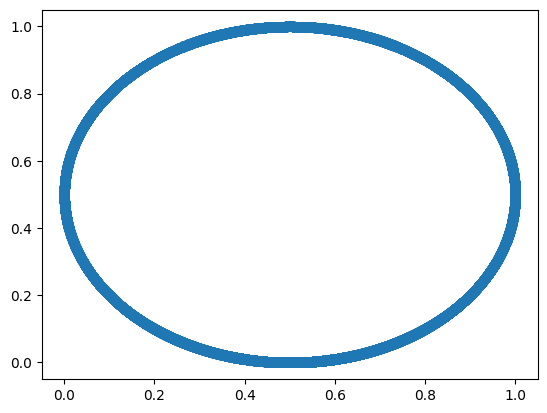

In [52]:
plt.scatter(dat_te[:, 0], dat_te[:, 1]) 
with torch.no_grad():
    
    